# **TAREFA - MODELAGEM DE PROJEÇÃO**
### *Case: Potencial de Novos Clientes* (base de dados: Potencial_Novos_Clientes.txt)
##### Uma rede de lojas de departamento deseja estimar o gasto potencial futuro de novos clientes que adquiriram o cartão de débito exclusivo da loja (private label), após completarem três meses de posse do cartão. A previsão se refere ao período dos 12 meses seguintes e se refere apenas a compras realizadas nas lojas da rede, onde há benefícios exclusivos, apesar de o cartão também poder ser utilizado em outros estabelecimentos ou e-commerce.
##### As seguintes variáveis estão disponíveis:
* *COD_CARTAO:* Código de identificação do cartão
* *IDADE_CLIENTE:* Idade do cliente, em anos
* *RENDA_MENSAL_CLIENTE:* Renda mensal declarada pelo cliente, em R$
* *BEHAVIOUR_SCORE_CLIENTE:* Behaviour score do cliente (avalia o comportamento financeiro e de consumo como um todo)
* *QTD_TRANSACOES_3M:* Quantidade de transações realizadas no cartão nas lojas da rede, nos 3 primeiros meses de posse
* *QTD_ITENS_3M:* Quantidade de itens comprados no cartão nas lojas da rede, nos 3 primeiros meses de posse
* *VALOR_GASTO_3M:* Valor total gasto no cartão nas lojas da rede, nos 3 primeiros meses de posse
* *TICKET_MEDIO_3M:* Valor médio gasto em transações no cartão nas lojas da rede, nos 3 primeiros meses de posse
* *FLAG_ELETRONICOS_3M:* Indica se o cliente comprou algum item da categoria eletrônicos, nos 3 primeiros meses de posse
* *SATISFACAO_ULTIMA_COMPRA:* Nível de satisfação do cliente em relação a sua última experiência de compra, em pesquisa de participação não obrigatória
* *VALOR_GASTO_PROX_12M:* Valor total gasto no cartão nas lojas da rede, nos 12 meses seguintes

##### Realize uma análise exploratória da base de dados, de forma univariada e bivariada, cruzando cada *feature* com o *target*. Em seguida, utilize diferentes algoritmos de projeção para predizer o valor total gasto no cartão nas lojas da rede, nos 12 meses seguintes. Proponha um modelo final, como base na estimativa do seu desempenho em dados apartados, e interprete a força e sentido de discriminância de suas variáveis. Atente-se às boas práticas de modelagem vistas em aula.

##### **Entregável**: notebook do Python (extensão .ipynb) já compilado, subdividido de acordo com as seções abaixo. Comente os resultados de todas as análises conduzidas.


### CARREGAMENTO DE BIBLIOTECAS

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector, ColumnTransformer          # Transformação e seleção de variáveis
from sklearn.preprocessing import StandardScaler, OneHotEncoder              # Padronização de quantitativas e criação de dummies para qualitativas
from sklearn.linear_model import LinearRegression                            # Regressão linear
from sklearn.tree import DecisionTreeRegressor                               # Árvore de decisão
from sklearn.ensemble import RandomForestRegressor                           # Floresta aleatória
from sklearn.ensemble import AdaBoostRegressor                               # AdaBoost
from sklearn.ensemble import GradientBoostingRegressor                       # Gradient boosting
from xgboost import XGBRegressor                                             # XGBoost
from lightgbm import LGBMRegressor                                           # LightGBM
from sklearn.model_selection import KFold, cross_validate                    # Validação cruzada
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV         # Otimização de hiperparâmetros via grid search e random search
import shap                                                                  # Interpretabilidade de modelos de ML

### LEITURA DA BASE DE DADOS

In [ ]:
# Leitura da base de dados
dados = pd.read_table("Potencial_Novos_Clientes.txt",
                      decimal = ".",
                      sep = "\t")

In [ ]:
pd.DataFrame(dados.dtypes)

,0
COD_CARTAO,int64
IDADE_CLIENTE,int64
RENDA_MENSAL_CLIENTE,int64
BEHAVIOUR_SCORE_CLIENTE,int64
QTD_TRANSACOES_3M,int64
QTD_ITENS_3M,int64
VALOR_GASTO_3M,int64
TICKET_MEDIO_3M,float64
FLAG_ELETRONICOS_3M,int64
SATISFACAO_ULTIMA_COMPRA,object


In [ ]:
display(dados)

,COD_CARTAO,IDADE_CLIENTE,RENDA_MENSAL_CLIENTE,BEHAVIOUR_SCORE_CLIENTE,QTD_TRANSACOES_3M,QTD_ITENS_3M,VALOR_GASTO_3M,TICKET_MEDIO_3M,FLAG_ELETRONICOS_3M,SATISFACAO_ULTIMA_COMPRA,VALOR_GASTO_PROX_12M
0,212394,22,1500,52,2,4,802,401.00,0,01_Muito_Satisfeito,226
1,279177,29,1800,94,5,5,1384,276.80,1,03_Neutro,2786
2,291430,36,1500,89,5,6,1610,322.00,1,Nao_Respondeu,3737
3,176612,43,1500,48,3,4,836,278.67,0,01_Muito_Satisfeito,1162
4,223092,28,12090,89,4,5,1318,329.50,0,Nao_Respondeu,2699
...,...,...,...,...,...,...,...,...,...,...,...
2925,278405,33,6810,65,4,5,1568,392.00,1,01_Muito_Satisfeito,2793
2926,273268,32,9720,54,2,5,1433,716.50,0,02_Satisfeito,1256
2927,246605,39,11325,88,5,6,1810,362.00,0,Nao_Respondeu,3729
2928,256984,61,16770,71,2,7,1310,655.00,0,Nao_Respondeu,1621


### ANÁLISE EXPLORATÓRIA UNIVARIADA

In [ ]:
dados.describe()

,COD_CARTAO,IDADE_CLIENTE,RENDA_MENSAL_CLIENTE,BEHAVIOUR_SCORE_CLIENTE,QTD_TRANSACOES_3M,QTD_ITENS_3M,VALOR_GASTO_3M,TICKET_MEDIO_3M,FLAG_ELETRONICOS_3M,VALOR_GASTO_PROX_12M
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,243018.692491,39.683959,8123.525597,75.965188,3.146758,5.516382,1109.693174,416.869297,0.251536,2041.454949
std,66402.270593,13.820502,6721.413629,14.813262,1.688522,2.002535,505.291585,237.148670,0.433970,1948.978989
min,127623.000000,18.000000,1500.000000,27.000000,1.000000,1.000000,79.000000,78.600000,0.000000,0.000000
25%,185502.000000,29.000000,1500.000000,67.000000,2.000000,4.000000,738.000000,265.690000,0.000000,713.500000
50%,244112.500000,37.000000,7050.000000,78.000000,3.000000,5.000000,1054.000000,350.375000,0.000000,1483.500000
75%,301528.500000,48.000000,12510.000000,88.000000,4.000000,7.000000,1351.000000,480.000000,1.000000,2820.000000
max,359853.000000,92.000000,66160.000000,99.000000,16.000000,28.000000,5259.000000,2266.000000,1.000000,16376.000000


Podemos observar a ausência de valores nulos e os dados estatísticos como máximo, minímo, desvio padrão e percentis das variáveis quantitativas.

In [ ]:
dados['SATISFACAO_ULTIMA_COMPRA'].value_counts()

,count
SATISFACAO_ULTIMA_COMPRA,
Nao_Respondeu,1043
02_Satisfeito,923
03_Neutro,613
01_Muito_Satisfeito,185
04_Insatisfeito,99
05_Muito_Insatisfeito,67


In [ ]:
dados['SATISFACAO_ULTIMA_COMPRA'].value_counts(normalize = True).round(2)

,proportion
SATISFACAO_ULTIMA_COMPRA,
Nao_Respondeu,0.36
02_Satisfeito,0.32
03_Neutro,0.21
01_Muito_Satisfeito,0.06
04_Insatisfeito,0.03
05_Muito_Insatisfeito,0.02


A variável "SATISFACAO_ULTIMA_COMPRA" tem a maior proporção e frequências no status "Nao_Respondeu", seguido pelo status "02_Satisfeito".

### ANÁLISE EXPLORATÓRIA BIVARIADA

Criando a variável "faixa_valor_gasto_12m" que variam de 1000 em 1000, afim de melhorar a interpretação dos gráficos da analise Bivariada.

In [ ]:
# Criar os rótulos personalizados para cada faixa de 1000 em 1000
bins = range(0, dados['VALOR_GASTO_PROX_12M'].max() + 1000, 1000)
labels = [f'{i}-{i+1000}' for i in bins[:-1]]

# Criar a coluna de faixa de valores
dados['faixa_valor_gasto_12m'] = pd.cut(dados['VALOR_GASTO_PROX_12M'], bins=bins, labels=labels, right=False)

display(dados)

,COD_CARTAO,IDADE_CLIENTE,RENDA_MENSAL_CLIENTE,BEHAVIOUR_SCORE_CLIENTE,QTD_TRANSACOES_3M,QTD_ITENS_3M,VALOR_GASTO_3M,TICKET_MEDIO_3M,FLAG_ELETRONICOS_3M,SATISFACAO_ULTIMA_COMPRA,VALOR_GASTO_PROX_12M,faixa_valor_gasto_12m
0,212394,22,1500,52,2,4,802,401.00,0,01_Muito_Satisfeito,226,0-1000
1,279177,29,1800,94,5,5,1384,276.80,1,03_Neutro,2786,2000-3000
2,291430,36,1500,89,5,6,1610,322.00,1,Nao_Respondeu,3737,3000-4000
3,176612,43,1500,48,3,4,836,278.67,0,01_Muito_Satisfeito,1162,1000-2000
4,223092,28,12090,89,4,5,1318,329.50,0,Nao_Respondeu,2699,2000-3000
...,...,...,...,...,...,...,...,...,...,...,...,...
2925,278405,33,6810,65,4,5,1568,392.00,1,01_Muito_Satisfeito,2793,2000-3000
2926,273268,32,9720,54,2,5,1433,716.50,0,02_Satisfeito,1256,1000-2000
2927,246605,39,11325,88,5,6,1810,362.00,0,Nao_Respondeu,3729,3000-4000
2928,256984,61,16770,71,2,7,1310,655.00,0,Nao_Respondeu,1621,1000-2000


Interessante observar que a mediana aumenta conforme irá aumentando a faixa.

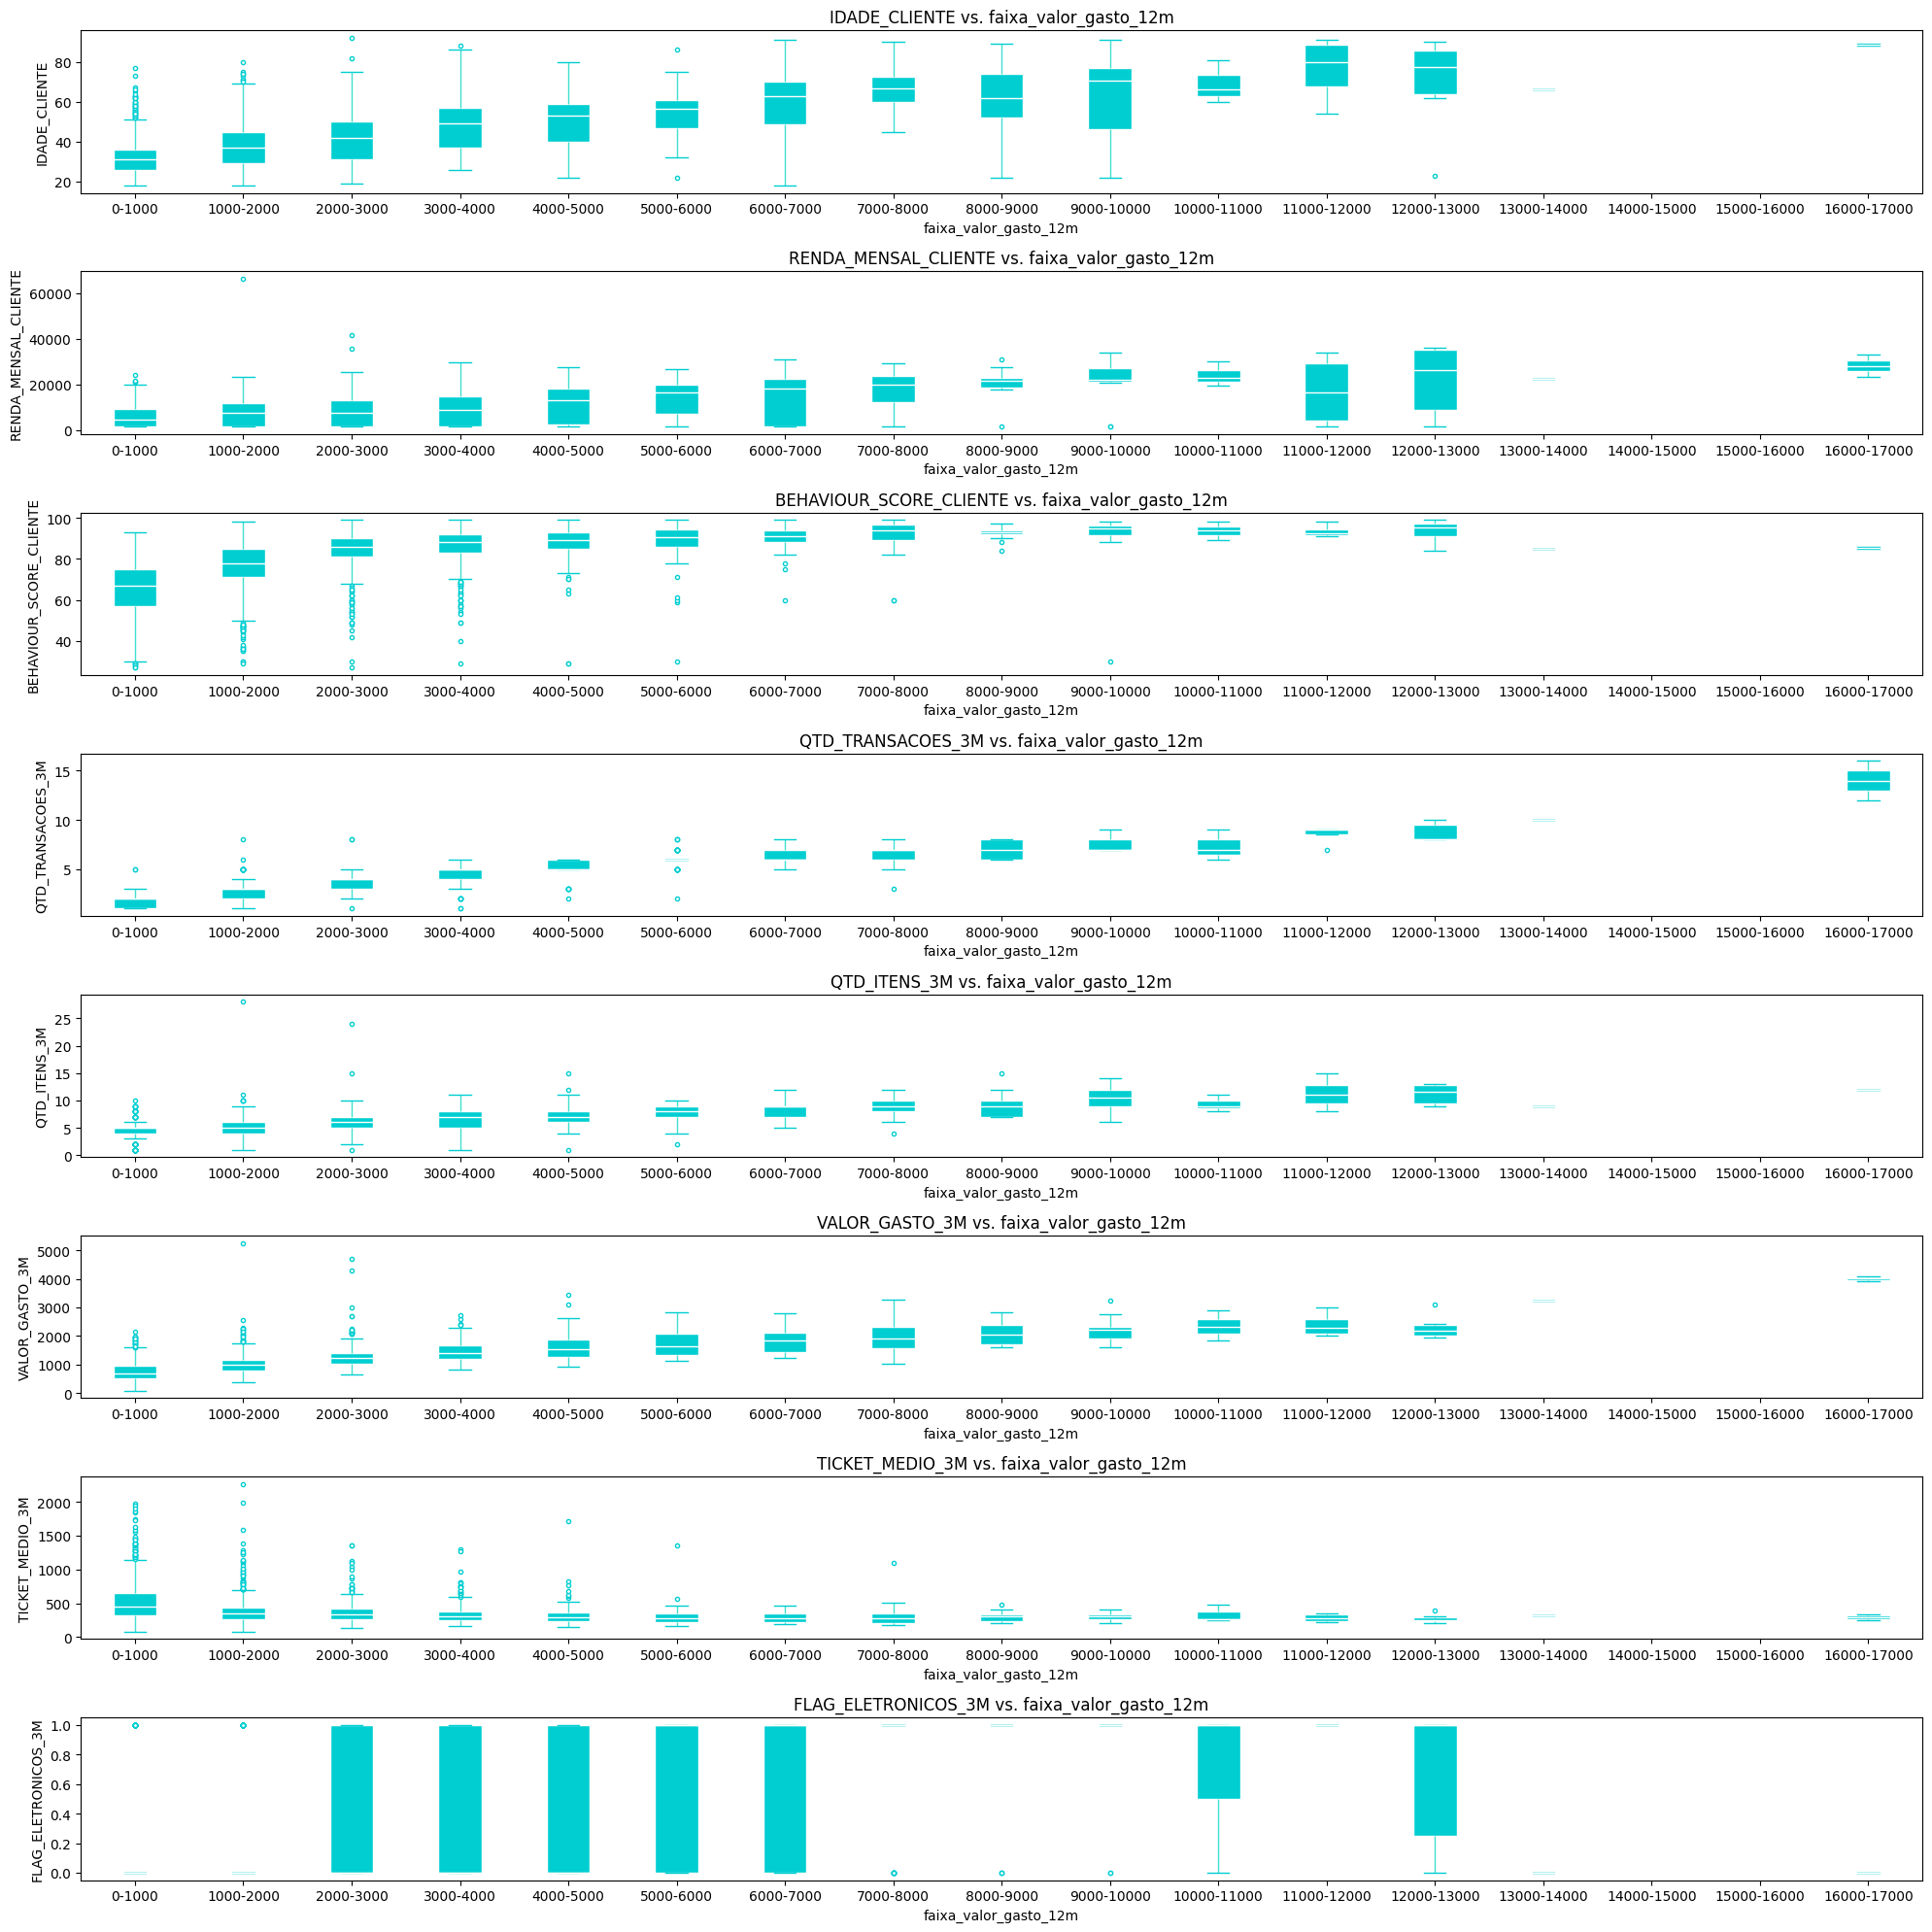

In [ ]:
# Gráfico de boxplots: variáveis explicativas quantitativas versus a faixa de valores

fig, axes = plt.subplots(nrows = 8, ncols = 1, figsize = (20, 20))

variaveis = ['IDADE_CLIENTE', 'RENDA_MENSAL_CLIENTE', 'BEHAVIOUR_SCORE_CLIENTE','QTD_TRANSACOES_3M','QTD_ITENS_3M','VALOR_GASTO_3M',
             'TICKET_MEDIO_3M','FLAG_ELETRONICOS_3M']

for ax, variavel in zip(axes.flat, variaveis):

  sns.boxplot(y = variavel,
              x = 'faixa_valor_gasto_12m',
              data = dados,
              width = 0.4,
              boxprops = {'facecolor':'darkturquoise', 'edgecolor':'white'},
              whiskerprops = {'color':'turquoise'},
              capprops     = {'color': 'darkturquoise'},
              medianprops  = {'color':'white'},
              flierprops   = {'markerfacecolor': 'white', 'markeredgecolor': 'darkturquoise', 'marker': 'o', 'markersize': 3, 'color': 'turquoise', 'linestyle': 'none'},
              ax = ax)
  ax.set_title(f'{variavel} vs. faixa_valor_gasto_12m')

plt.tight_layout()
plt.show()

Interessante observar que a concentração da dispersão aumenta conforme menor é a faixa.

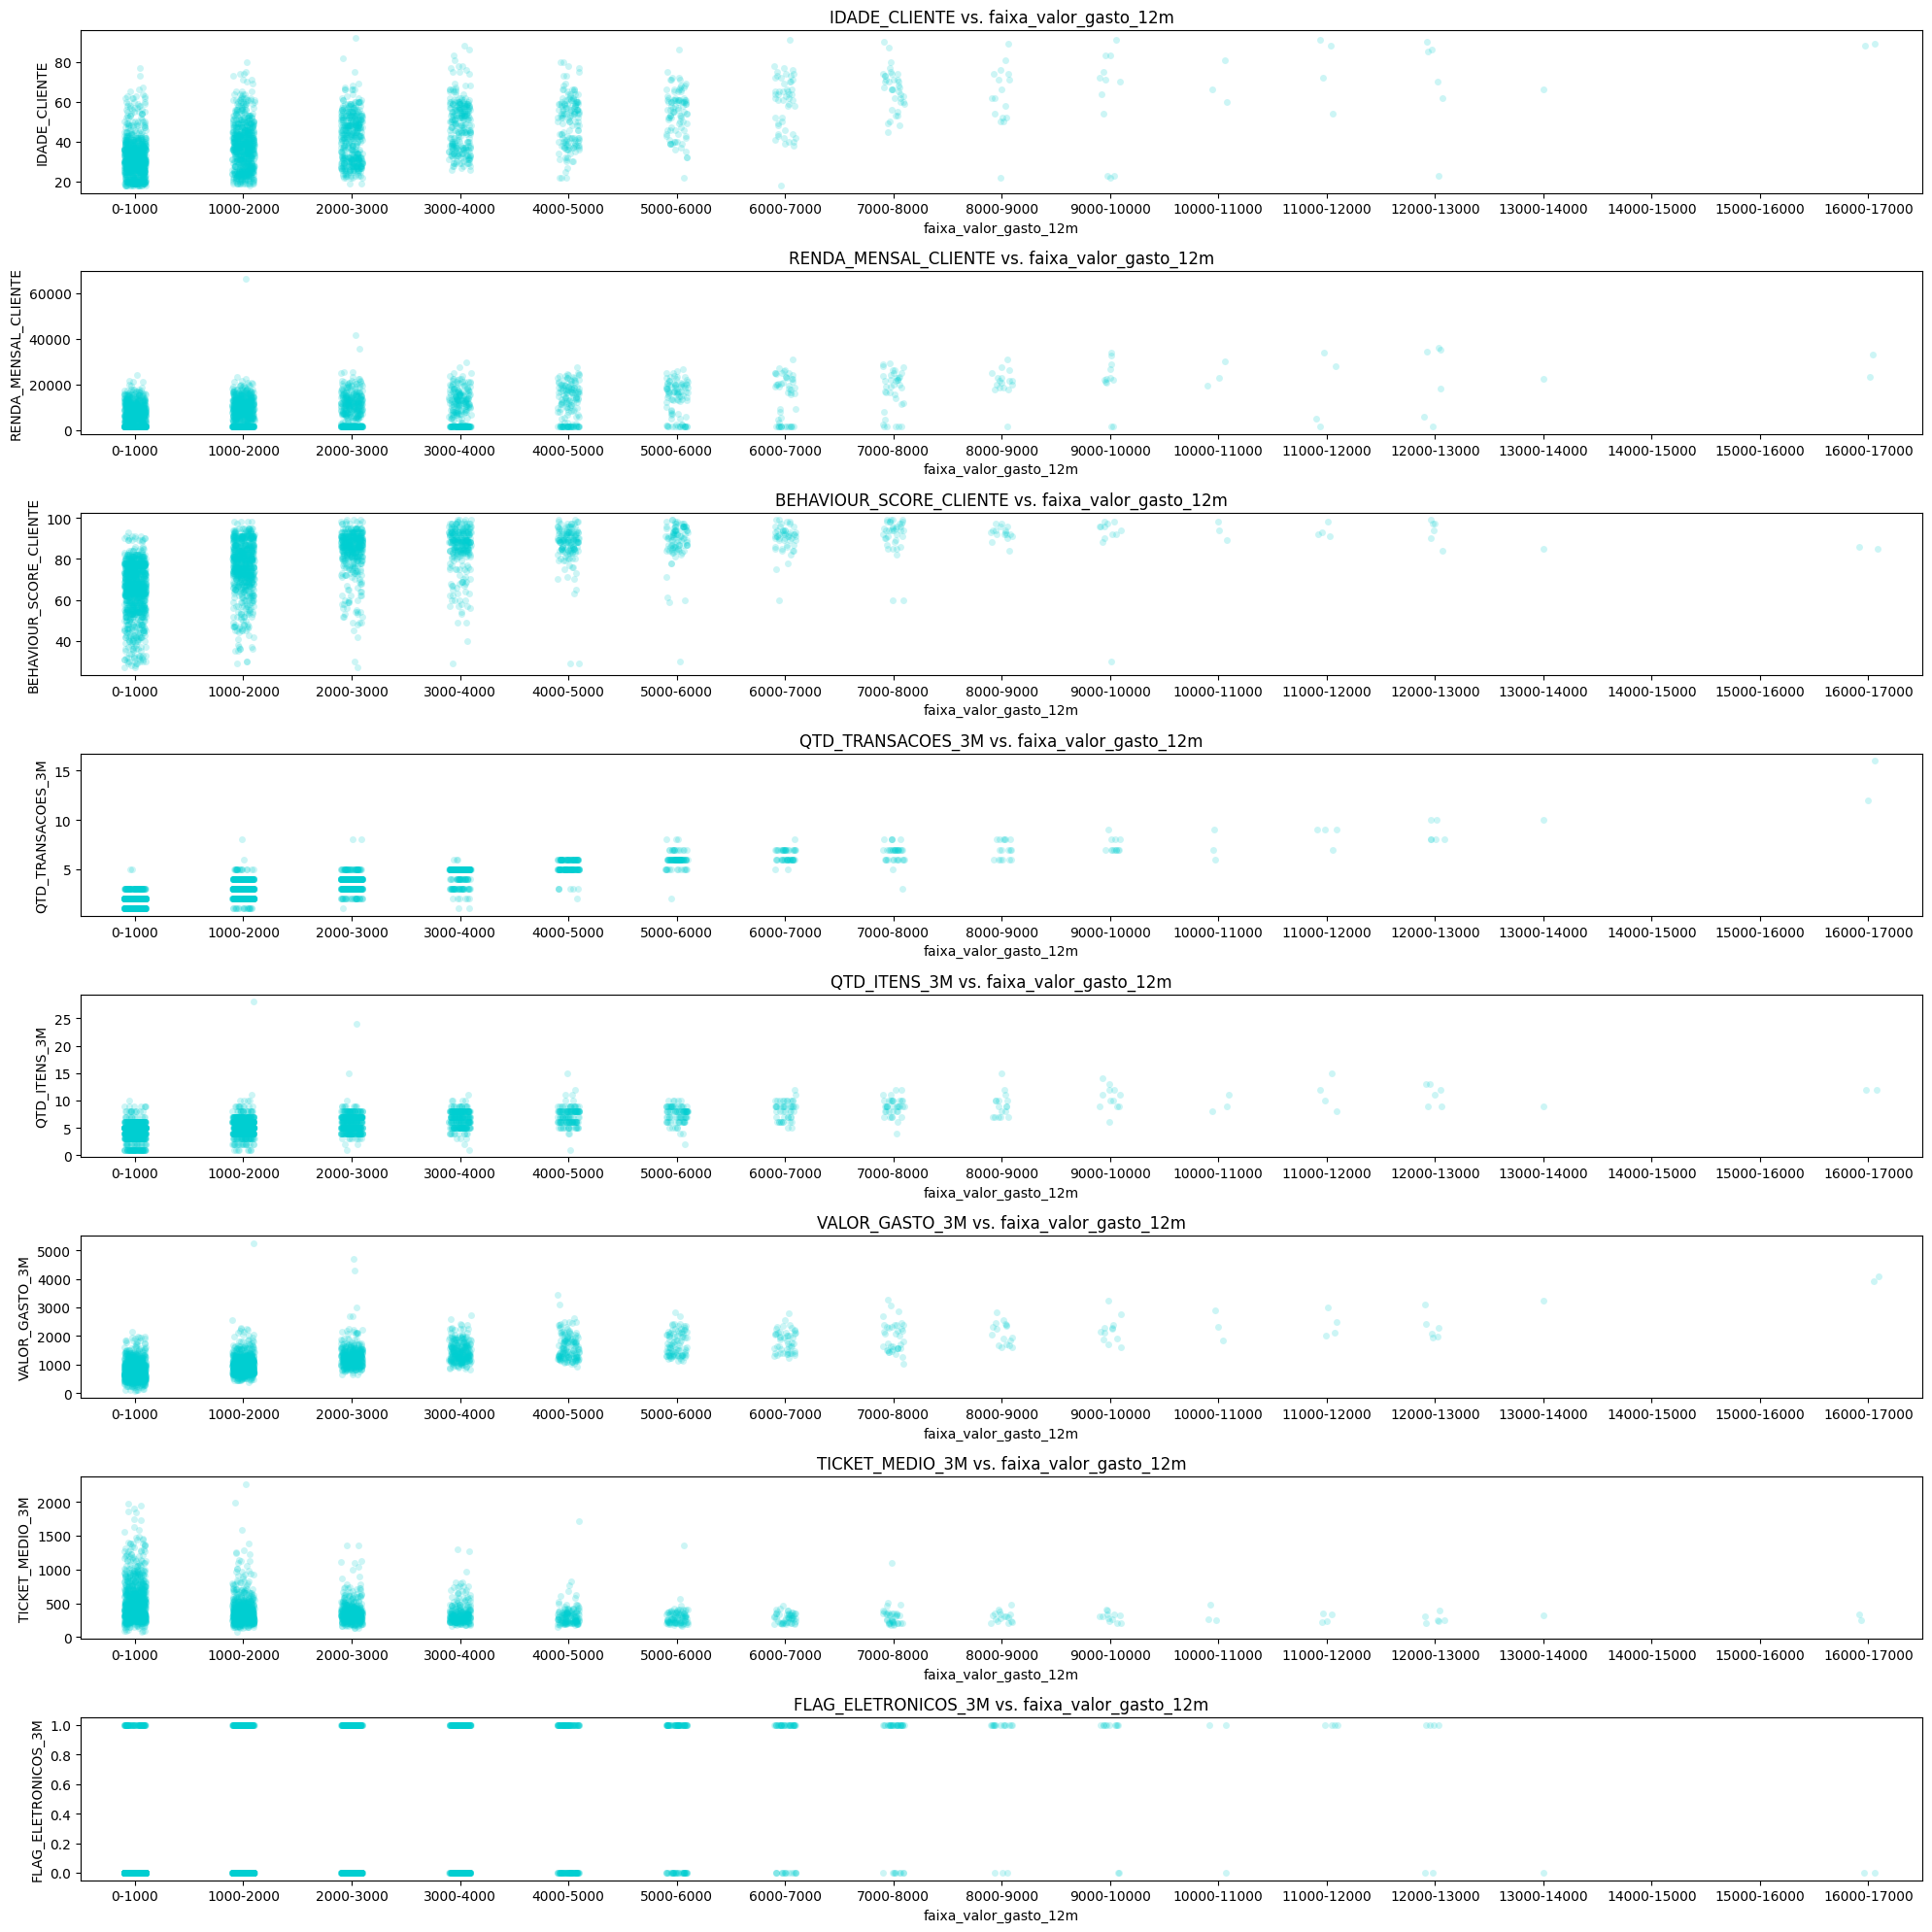

In [ ]:
# Gráfico de stripplots: alternativa aos boxplots, em formato de dispersão

fig, axes = plt.subplots(nrows = 8, ncols = 1, figsize = (20, 20))

variaveis = ['IDADE_CLIENTE', 'RENDA_MENSAL_CLIENTE', 'BEHAVIOUR_SCORE_CLIENTE','QTD_TRANSACOES_3M','QTD_ITENS_3M','VALOR_GASTO_3M',
             'TICKET_MEDIO_3M','FLAG_ELETRONICOS_3M']

for ax, variavel in zip(axes.flat, variaveis):
    sns.stripplot(x = 'faixa_valor_gasto_12m',
                  y = variavel,
                  data = dados,
                  color = 'darkturquoise',
                  jitter = True,
                  alpha = 0.2,
                  ax = ax)
    ax.set_title(f'{variavel} vs. faixa_valor_gasto_12m')

plt.tight_layout()
plt.show()

Ao plotar a matriz de correção, podemos observar que a variável "QTD_TRANSACOES_3M" tem a maior correlação com a varíavel "VALOR_GASTO_PROX_12M", seguido pela variável "VALOR_GASTO_3M".

In [ ]:
# Matriz de correlações lineares entre as variáveis quantitativas
matriz_cor = dados.drop(columns = ['SATISFACAO_ULTIMA_COMPRA', 'COD_CARTAO','faixa_valor_gasto_12m']).corr().iloc[:-1, :]
matriz_cor

,IDADE_CLIENTE,RENDA_MENSAL_CLIENTE,BEHAVIOUR_SCORE_CLIENTE,QTD_TRANSACOES_3M,QTD_ITENS_3M,VALOR_GASTO_3M,TICKET_MEDIO_3M,FLAG_ELETRONICOS_3M,VALOR_GASTO_PROX_12M
IDADE_CLIENTE,1.000000,0.385506,0.324672,0.518375,0.719565,0.470375,-0.046300,0.214885,0.608537
RENDA_MENSAL_CLIENTE,0.385506,1.000000,0.294337,0.349671,0.520138,0.198055,-0.204715,0.048114,0.436511
BEHAVIOUR_SCORE_CLIENTE,0.324672,0.294337,1.000000,0.601201,0.423735,0.216925,-0.489471,0.463042,0.538491
QTD_TRANSACOES_3M,0.518375,0.349671,0.601201,1.000000,0.582695,0.637534,-0.504861,0.437893,0.888013
QTD_ITENS_3M,0.719565,0.520138,0.423735,0.582695,1.000000,0.439846,-0.213852,0.280279,0.621787
VALOR_GASTO_3M,0.470375,0.198055,0.216925,0.637534,0.439846,1.000000,0.196981,0.151554,0.701666
TICKET_MEDIO_3M,-0.046300,-0.204715,-0.489471,-0.504861,-0.213852,0.196981,1.000000,-0.267182,-0.294270
FLAG_ELETRONICOS_3M,0.214885,0.048114,0.463042,0.437893,0.280279,0.151554,-0.267182,1.000000,0.402858


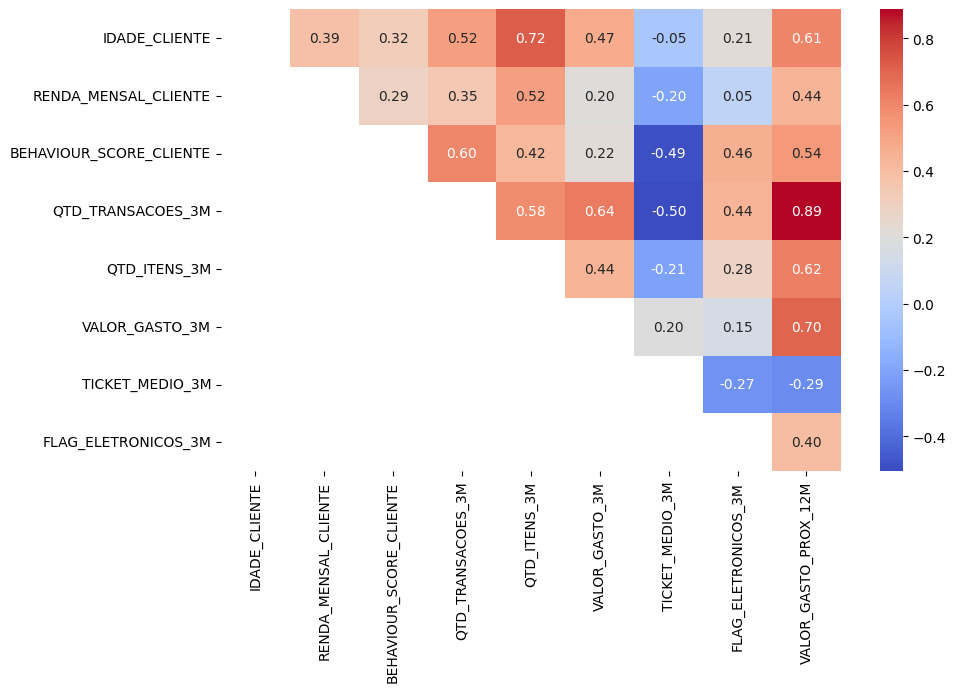

In [ ]:
# Exibição da matriz de correlações lineares, em formato de gráfico de calor
plt.figure(figsize = (10, 6))
mask = np.tril(np.ones_like(matriz_cor, dtype = bool)) # para ocultar valores no triângulo abaixo da diagonal
sns.heatmap(matriz_cor, annot = True, fmt = '.2f', cmap = 'coolwarm', mask = mask)
plt.show()

### FLUXO DE MODELAGEM

## Separação de features e target

In [ ]:
valores_0 = dados.query('VALOR_GASTO_PROX_12M == 0').VALOR_GASTO_PROX_12M.count()
total_base = dados['VALOR_GASTO_PROX_12M'].count()

print(f'Total e linhas com valor 0: {valores_0}')
print(f'Tottal de linhas na base: {total_base}')
print(f'Precentual de 0 na base: {round((valores_0/total_base)*100,2)}%')

Total e linhas com valor 0: 260
Tottal de linhas na base: 2930
Precentual de 0 na base: 8.87%


Podemos observar que temos 8% de valores 0 na variável "VALOR_GASTO_PROX_12M", podendo então indicar um comportamento natural de alguns clientes a não gastar, ou seja, devemos considera-los no modelo. A partir deste ponto o ideal é não levar em consideração a métrica MAPE, pois ela deve receber um valor irreal devido as comparações com os valores 0.

Separação de features e target

In [ ]:
X = dados.drop(columns = ['COD_CARTAO', 'VALOR_GASTO_PROX_12M', 'faixa_valor_gasto_12m'])
y = dados['VALOR_GASTO_PROX_12M']

## Cópias das features e target

In [ ]:
X_sample = X
y_sample = y

## Redução do tamanho da amostra

Irei amostrar os dados em 1000 linhas de forma aleatória, para melhorar o desempenho do algoritímo, posteriormente irá ser aplicado para base toda.

In [ ]:
np.random.seed(123)
indices = np.random.choice(X.index, size = 1000, replace = False)
X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

## Pré-processamento de variáveis explicativas: padronização e criação de dummies

Neste item irei pré-processar os dados categóricos, criando dummies para estas features.

In [ ]:
# Pré-processamento automático, com base nos tipos das variáveis
pre_processamento = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop = 'first'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

## Lista de algoritmos e hiperparâmetros testados via random search

Irei testar os hiperparâmetros via random search, porque é mais otimizado falando do ponto de vista computacional.

In [ ]:
# Lista de algoritmos e hiperparâmetros testados (altere os valores conforme a necessidade)
modelos = {
    'REGRESSÃO LINEAR': (LinearRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE REGRESSÃO': (DecisionTreeRegressor(), {
        'criterion': ['squared_error', 'absolute_error'],
        'min_samples_leaf': np.arange(20, 101),
        'max_depth': np.arange(2, 11)
    }),
    'FLORESTA ALEATÓRIA': (RandomForestRegressor(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'criterion': ['squared_error', 'absolute_error'],
        'min_samples_leaf': np.arange(20, 101),
        'max_depth': np.arange(2, 11)
    }),
    'ADABOOST': (AdaBoostRegressor(loss = 'square'), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01)
    }),
    'GRADIENT BOOSTING': (GradientBoostingRegressor(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_samples_leaf': np.arange(20, 101)
    }),
    'XGBOOST': (XGBRegressor(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_child_weight': np.arange(1, 11),
        'gamma': np.arange(0, 1.1, 0.1)
    }),
    'LIGHTGBM': (LGBMRegressor(verbose = -1, importance_type = 'gain', n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_data_in_leaf': np.arange(20, 101)
    })
}

## Estimativa de desempenho por meio de validação cruzada aninhada

In [ ]:
# Aplicação do pré-processamento
X_transformed = pre_processamento.fit_transform(X)
X_sample_transformed = X_transformed[X_sample.index]

In [ ]:
# Auxiliares para armazenamento do melhor modelo
melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

Irei utilizar a validação cruzada, pois é mais robusto e recomendado, assegurando a sua capacidade de extrapolação

In [ ]:
# Quantidade de folds nas camadas interna e externa (substitua KFold por StratifiedKFold se necessário)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

In [ ]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 'neg_mean_absolute_error': 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error', 'r2': 'r2'}

  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_neg_root_mean_squared_error']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_neg_root_mean_squared_error'])

  # Resultados
  print(f'--- {nome} ---')
  print("Média de RMSE: " + str(-round(np.mean(nested_scores['test_neg_root_mean_squared_error']), 3)))
  print("D.P. de RMSE: " + str(round(np.std(nested_scores['test_neg_root_mean_squared_error']), 3)))
  print("Média de MAE: " + str(-round(np.mean(nested_scores['test_neg_mean_absolute_error']), 3)))
  print("D.P. de MAE: " + str(round(np.std(nested_scores['test_neg_mean_absolute_error']), 3)))
  print("Média de MAPE: " + str(-round(np.mean(nested_scores['test_neg_mean_absolute_percentage_error']), 3)))
  print("D.P. de MAPE: " + str(round(np.std(nested_scores['test_neg_mean_absolute_percentage_error']), 3)))
  print("Média de R^2: " + str(round(np.mean(nested_scores['test_r2']), 3)))
  print("D.P. de R^2: " + str(round(np.std(nested_scores['test_r2']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- REGRESSÃO LINEAR ---
Média de RMSE: 707.521
D.P. de RMSE: 116.06
Média de MAE: 499.159
D.P. de MAE: 48.334
Média de MAPE: 1.9668564536731702e+17
D.P. de MAPE: 4.009343401253565e+16
Média de R^2: 0.851
D.P. de R^2: 0.028

--- ÁRVORE DE REGRESSÃO ---
Média de RMSE: 719.375
D.P. de RMSE: 108.628
Média de MAE: 477.724
D.P. de MAE: 35.332
Média de MAPE: 8.420632078312115e+16
D.P. de MAPE: 5995536828906632.0
Média de R^2: 0.847
D.P. de R^2: 0.024

--- FLORESTA ALEATÓRIA ---
Média de RMSE: 726.31
D.P. de RMSE: 154.626
Média de MAE: 466.181
D.P. de MAE: 47.354
Média de MAPE: 9.68220676220273e+16
D.P. de MAPE: 1.1622031905213302e+16
Média de R^2: 0.845
D.P. de R^2: 0.036

--- ADABOOST ---
Média de RMSE: 768.881
D.P. de RMSE: 96.701
Média de MAE: 582.319
D.P. de MAE: 37.811
Média de MAPE: 3.330566632339514e+17
D.P. de MAPE: 6.835328692249748e+16
Média de R^2: 0.824
D.P. de R^2: 0.028

--- GRADIENT BOOSTING ---
Média de RMSE: 611.504
D.P. de RMSE: 94.448
Média de MAE: 397.549
D.P. de MAE: 33.

O melhor algoritmo é o GRADIENT BOOSTING, analisando no seu RMSE:

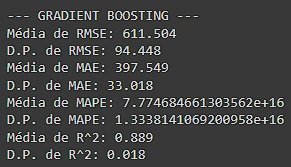

## Ajuste de modelo final na base de desenvolvimento, usando validação cruzada

In [ ]:
# Quantidade de folds
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)

In [ ]:
# Métricas de interesse
scoring = {'neg_root_mean_squared_error': 'neg_root_mean_squared_error', 'neg_mean_absolute_error': 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error', 'r2': 'r2'}

In [ ]:
# modelo_final = GridSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_jobs = -1)
modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'neg_root_mean_squared_error', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores hiperparâmetros para GRADIENT BOOSTING: {'n_estimators': 150, 'min_samples_leaf': 22, 'max_depth': 3, 'learning_rate': 0.16}


Os Melhores hiperparâmetros para o algoritímo são: {'n_estimators': 150, 'min_samples_leaf': 22, 'max_depth': 3, 'learning_rate': 0.16}

## Importância das features do modelo final

Aqui irei utilizar o Gini e o Shap para explicabilidade do modelo

In [ ]:
# Auxiliar: nomes das features após pré-processamento
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_qualitativas) + list(features_quantitativas)

In [ ]:
# Cálculo de medida de importância de Gini
importancias = modelo_final.best_estimator_.feature_importances_

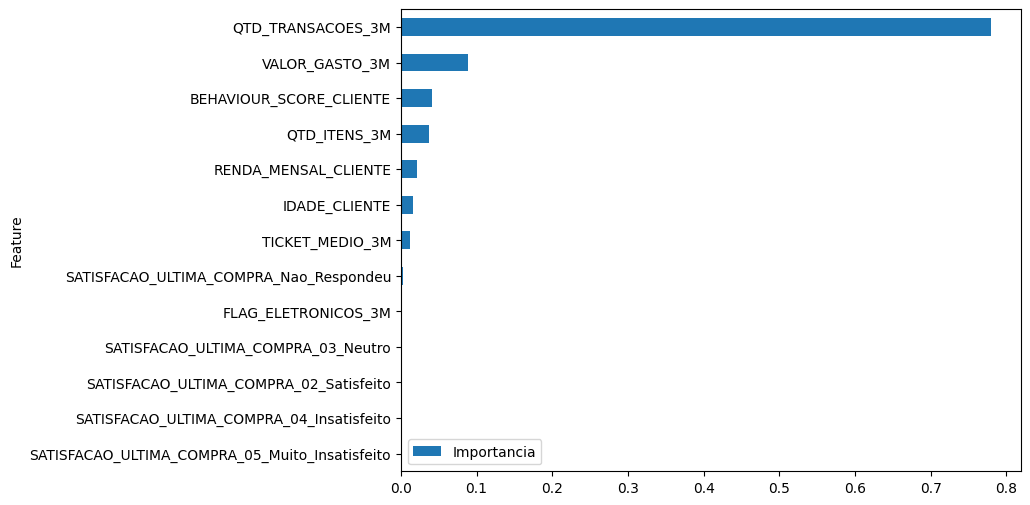

In [ ]:
# Gráfico das importâncias de Gini (ajuste o argumento tail de acordo com a quantidade de barras que deseja visualizar)
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True).tail(20)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP.")
else:
  explainer = shap.Explainer(modelo_final.best_estimator_)
  valores_shap = explainer(X_sample_transformed)

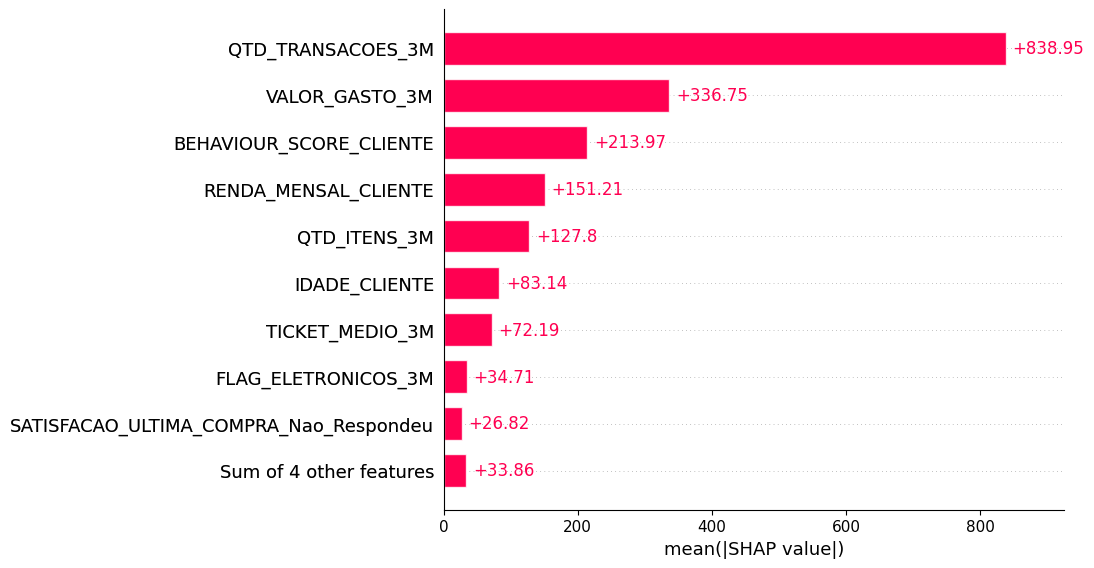

In [ ]:
# Gráfico do SHAP absoluto médio por feature
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP.")
else:
  shap.plots.bar(shap.Explanation(values = valores_shap, feature_names = features))

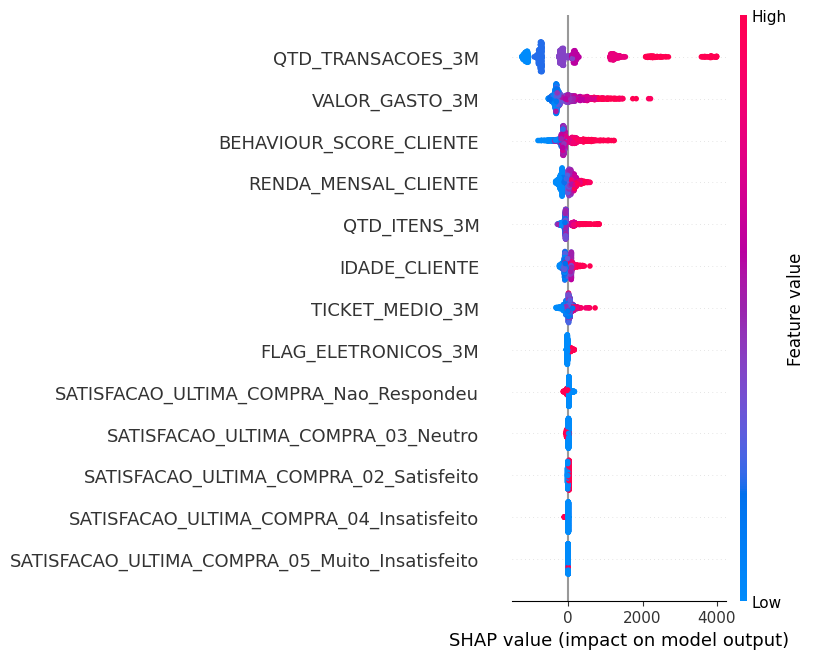

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
if melhor_algoritmo == 'ADABOOST':
  print("Cálculo de valores SHAP muito oneroso em modelos de projeção, usando AdaBost na biblioteca SHAP")
else:
  shap.summary_plot(shap.Explanation(values = valores_shap, feature_names = features))

## Aplicação de modelo final na base completa

Por fim irei aplicar o melhor algoritmo e os melhores hiperparâmetros identificados anteriormente para a base completa

In [ ]:
# Atribuição de valor predito
y_pred = modelo_final.best_estimator_.predict(X_transformed)

## Comparação gráfica de valores observados vs. valores preditos pelo modelo final

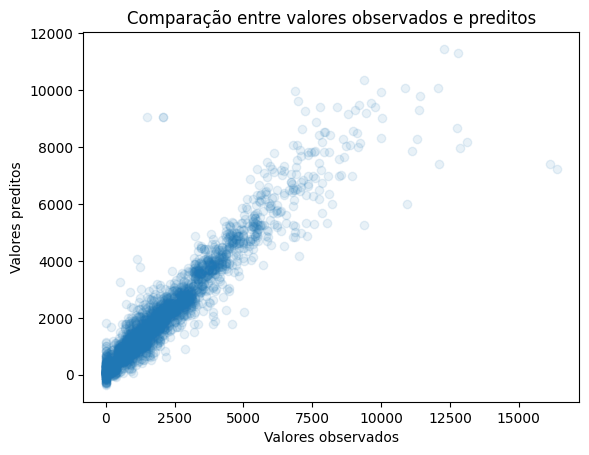

In [ ]:
plt.scatter(y, y_pred, alpha = 0.1)
plt.title('Comparação entre valores observados e preditos')
plt.xlabel('Valores observados')
plt.ylabel('Valores preditos')
plt.show()

### CONCLUSÕES FINAIS

A melhor solução de modelo de machine learning para projeção do valor total gasto no cartão nas lojas da rede, nos 12 meses seguintes é:
- Algoritmo: GRADIENT BOOSTING, baseado no seu melhor desempenho de RSME.

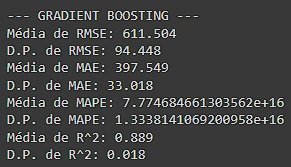
- Os melhores hiperparâmetros: n_estimators: 150, min_samples_leaf: 22, max_depth: 3, learning_rate: 0.16

image.png


Identificando as Top 5 variáveis mais importantes utilizando os métodos:
- Gini: QTD_TRANSACOES_3M, VALOR_GASTO_3M, BEHAIVOUR_SCORE_CLIENTE, QTD_ITENS_3M, RENDA_MENSAL_CLIENTE
- Shap: QTD_TRANSACOES_3M, VALOR_GASTO_3M, BEHAIVOUR_SCORE_CLIENTE, RENDA_MENSAL_CLIENTE, QTD_ITENS_3M

Observando as distribuições das top 5 variáveis mais importantes, utilizando Shap, podemos verificar o quanto cada variável influênciou positivamente, aumentando a probabilidade e o quanto influênciou negativamente, diminuindo a probabilidade.

Falando da variável mais importante, "QNTD_TRANSACOES_3M", podemos observar que, quanto maior a quantidade de transações dos últimos 3 meses, mais impacta positivamente nas probabilidades e quanto menor, mais impacta negativamente.

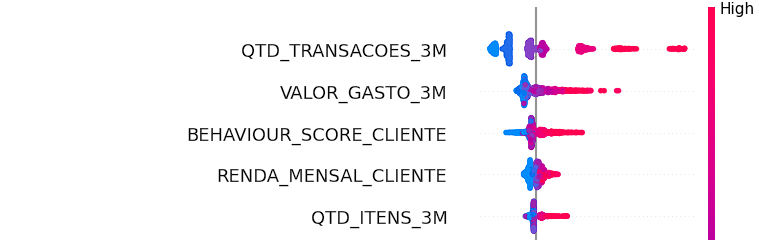


Olhando para o desempenho a partir do gráfico de dispersão entre os valores observados e preditos, é possível observar uma correlação positiva clara entre eles, o que indica que o modelo de Gradiente Boosting está capturando bem a relação entre as variáveis preditoras e o valor de gastos futuros.

No entanto, também há uma dispersão significativa para valores mais altos, o que pode indicar que o modelo apresenta uma certa dificuldade em prever valores de gastos maiores com a mesma precisão.

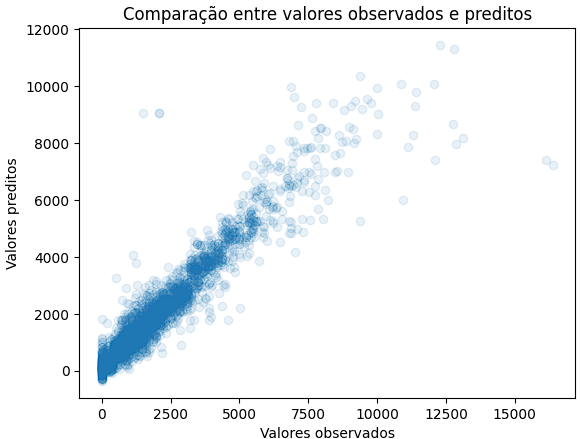
